In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import os

In [3]:
# 1. Dataset Loading and Exploration
def load_and_explore_data():
    print("Loading MNIST dataset...")
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Display dataset information
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Visualize sample images
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_train[i], cmap='gray')
        plt.title(f"Label: {y_train[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.close()
    
    return X_train, y_train, X_test, y_test

In [4]:
# 2. Data Preprocessing
def preprocess_data(X_train, y_train, X_test, y_test):
    # Normalize pixel values
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    # Reshape for CNN (add channel dimension)
    X_train = X_train.reshape((-1, 28, 28, 1))
    X_test = X_test.reshape((-1, 28, 28, 1))
    
    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return X_train, y_train, X_test, y_test


In [5]:
# 3. Data Augmentation
def create_data_augmentation():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

In [6]:
# 4. Build CNN Model
def build_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model


In [8]:
 #5. Training Callbacks
def create_callbacks():
    return [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        callbacks.TensorBoard(
            log_dir=f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}',
            histogram_freq=1
        )
    ]


In [9]:
# 6. Plot Training History
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

In [10]:
# 7. Evaluate Model
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate and print metrics
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

In [11]:

def main():
    # 1. Load and explore data
    X_train, y_train, X_test, y_test = load_and_explore_data()
    
    # 2. Preprocess data
    X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)
    
    # 3. Create data augmentation
    data_augmentation = create_data_augmentation()
    
    # 4. Build model
    model = build_model()
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("\nModel Summary:")
    model.summary()
    
    # 5. Train model
    print("\nTraining model...")
    history = model.fit(
        data_augmentation.flow(X_train, y_train, batch_size=32),
        epochs=25,
        validation_data=(X_test, y_test),
        callbacks=create_callbacks(),
        verbose=1
    )
    
    # 6. Plot training history
    plot_training_history(history)
    
    # 7. Evaluate model
    print("\nEvaluating model...")
    evaluate_model(model, X_test, y_test)
    
    # 8. Save model
    print("\nSaving model...")
    model.save('mnist_cnn_model.h5')
    print("Model saved as 'mnist_cnn_model.h5'")

if __name__ == "__main__":
    main()

Loading MNIST dataset...
11490434/11490434 [==============================] - 3s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)




Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (

c:\Users\divy2\Desktop\ImageClassification\mnist_cnn_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model loaded successfully.
1/1 [==============================] - 0s 172ms/step

Predictions for the first 5 digits in the test dataset:
Sample 1: Predicted: 7, True Label: 7
Sample 2: Predicted: 2, True Label: 2
Sample 3: Predicted: 1, True Label: 1
Sample 4: Predicted: 0, True Label: 0
Sample 5: Predicted: 4, True Label: 4


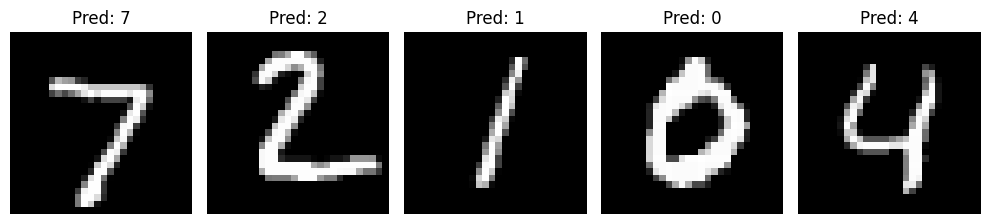

In [12]:
# 9. Test Model Performance
def test_model_performance(model, X_test, y_test):
    # Get predictions for the first 5 test samples
    predictions = model.predict(X_test[:5])
    
    # Convert predictions and true labels from one-hot encoding to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test[:5], axis=1)
    
    # Print predicted and true classes
    print("\nPredictions for the first 5 digits in the test dataset:")
    for i in range(5):
        print(f"Sample {i+1}: Predicted: {predicted_classes[i]}, True Label: {true_classes[i]}")
    
    # Plot the first 5 test samples with their predicted labels
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {predicted_classes[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('first_5_predictions.png')
    plt.show()

# 10. Loading the saved model and testing it
def load_and_test_model():
    # Load the trained model
    model = tf.keras.models.load_model('mnist_cnn_model.h5')
    print("\nModel loaded successfully.")
    
    # Load the MNIST test data (same as when we trained)
    (_, _), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Preprocess the data
    X_test = X_test.astype('float32') / 255
    X_test = X_test.reshape((-1, 28, 28, 1))
    y_test = to_categorical(y_test, 10)
    
    # Test model performance
    test_model_performance(model, X_test, y_test)

if __name__ == "__main__":
    load_and_test_model()
